In [ ]:
!apt install ffmpeg
!pip install alphashape
!pip install descartes
!pip install trackpy
!pip install pims

In [ ]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from descartes import PolygonPatch
import alphashape
from sklearn.metrics import DistanceMetric
import scipy.stats as stats
from google.colab import files
import pims
import trackpy as tp

In [ ]:
uploaded = files.upload()

Saving WhatsApp Video 2024-05-05 at 11.20.08 AM.mp4 to WhatsApp Video 2024-05-05 at 11.20.08 AM.mp4


In [ ]:
!rm *png
!mv "WhatsApp Video 2024-05-05 at 11.20.08 AM.mp4" test.avi
!ffmpeg -i test.avi %05d.png

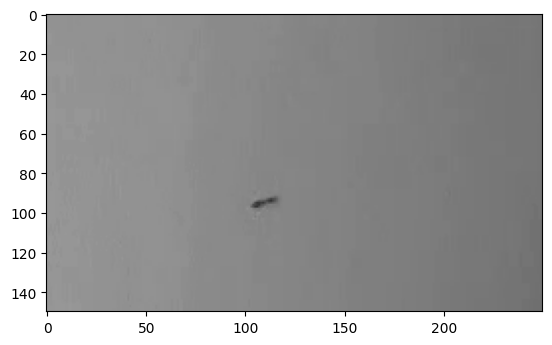

In [ ]:
# Original Image
file_path       = "00005.png"
original_image  = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

plt.imshow(cv2.cvtColor(original_image[200:350, 200:450], cv2.COLOR_BGR2RGB))
plt.show()

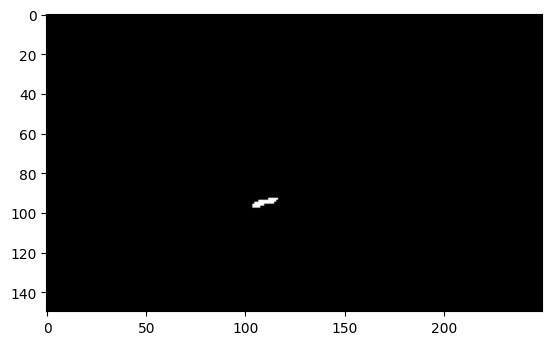

In [ ]:
# Binary Thresholding with 170 has been found to be a good choice
####################################################################
_,th_bin    = cv2.threshold(original_image,100,255,cv2.THRESH_BINARY)
th_bin_crop = th_bin[200:350, 200:450]
th_bin_crop = cv2.bitwise_not(th_bin_crop)

plt.imshow(cv2.cvtColor(th_bin_crop, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
th_bin_crop.shape

(150, 250)

In [ ]:
#Preprocessing to get uniform circles for trackpy
num_files = 50
for i in range(1, num_files + 1):
  filename        = f"{str(i).zfill(5)}.png"  # Pad with zeros to ensure 5-digit format
  original_image  = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  original_image  = original_image[200:350, 200:450]
  blank_image     = np.zeros(original_image.shape, dtype=original_image.dtype)

  # Binary Thresholding with 150 has been found to be a good choice
  _,th_bin    = cv2.threshold(original_image,100,255,cv2.THRESH_BINARY)
  th_bin      = cv2.bitwise_not(th_bin)

  #Finding contours
  contour = cv2.findContours(th_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  cnts    = [c for c in contour if cv2.contourArea(c) > 0] #Area must be a positive number

  for r in cnts:
    M = cv2.moments(r)
    if M['m00'] != 0:
      cx        = int(M['m10']/M['m00'])
      cy        = int(M['m01']/M['m00'])
      area_xy   = cv2.contourArea(r)
      radius_xy = int(np.sqrt(area_xy/np.pi))+1

      #center_xy.append([cx,cy,area_xy])
      cv2.circle(blank_image, (cx, cy), 7, (0,0,0), -1)       # this is overwriting blank_bw_image
      cv2.circle(blank_image, (cx, cy), 5, (255,255,255), -1) # this is overwriting blank_bw_image

  if i ==25:      #Print for checking
    print("Number of features for frame 25:", len(cnts))

  export_name = "export_"+ str(filename)
  #plt.figure(figsize=(int(original_image.shape[0]*2/72),
  #                   int(original_image.shape[1]*2/72)))
  plt.axis('off')
  plt.imshow(cv2.cvtColor(blank_image, cv2.COLOR_BGR2RGB))
  plt.savefig(export_name, bbox_inches='tight', pad_inches = 0)
  plt.close()

Number of features for frame 25: 1


In [ ]:
original_image.shape

(150, 250)

In [ ]:
file_path       = "export_00001.png"
export_image    = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
export_image.shape

(297, 496)

In [ ]:
#Read multiple images from the directory
#Also, convert the images to grey by just using the green channel image
#We can also use built in method: pims.as_grey
@pims.pipeline
def gray(image):
    return image[:, :, 1]  # Take just the green channel

frames = gray(pims.open('/content/export_*.png'))

In [ ]:
#Optimize search radius
for i in range(3,20,2):
  f = tp.locate(frames[24], i)
  print("No. of features for radius", i, "is", len(f))

No. of features for radius 3 is 12
No. of features for radius 5 is 5
No. of features for radius 7 is 4
No. of features for radius 9 is 4
No. of features for radius 11 is 1
No. of features for radius 13 is 1
No. of features for radius 15 is 1
No. of features for radius 17 is 1
No. of features for radius 19 is 1


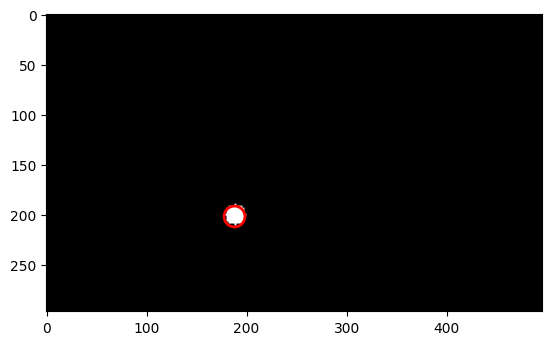

<Axes: >

In [ ]:
#Radius =7 is the most accurate.
f = tp.locate(frames[0], 19)
# As it can be seen, radius 7 has detected features perfectly
tp.annotate(f, frames[0])

In [ ]:
# We use tp.batch, which calls tp.locate on each frame to locate features on each frame
f          = tp.batch(frames[:50], 19)   # first 75 frames, radius 7
t          = tp.link(f, 17, memory=5)   # Link features into particle trajectories. maximum displacement is 17 pixel

Frame 49: 1 trajectories present.


In [ ]:
t

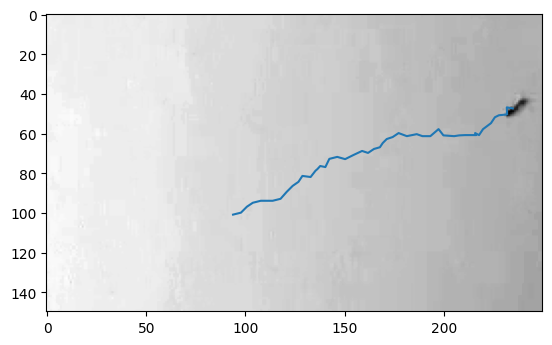

In [ ]:
# Create a figure and axes
fig, ax = plt.subplots()

# Plot the image
ax.imshow(original_image, cmap="gray")
ax.plot(t['x']/2, t['y']/2, '-')

In [ ]:
#Preprocessing to get uniform circles for trackpy
num_files = 50
for i in range(1, num_files + 1):
  filename        = f"{str(i).zfill(5)}.png"  # Pad with zeros to ensure 5-digit format
  original_image  = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
  original_image  = original_image[200:350, 200:450]

  export_name = "track_export_"+ str(filename)

  # Create a figure and axes
  fig, ax = plt.subplots()

  # Plot the image
  ax.imshow(original_image, cmap="gray")
  ax.plot(t['x']/2, t['y']/2, '-')

  plt.savefig(export_name, bbox_inches='tight', pad_inches = .1)
  plt.close()

In [ ]:
!ffmpeg -framerate 5 -i track_export_%5d.png -c:v libx264 track_output.avi